<a href="https://colab.research.google.com/github/RayapatiDeepthi/Lung-Cancer-Detection-using-Keras/blob/main/Drug_Hack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf  # Library for neural networks
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K  # Operations for mathematics in Keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For loading image data into the model
import tensorflow_addons as tfa  # Additional functionalities for TensorFlow
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

from PIL import Image  # For displaying images
import cv2  # Computer vision library
import joblib  # Library for saving models as files
from joblib import Parallel, delayed  # For multi-processing

from tqdm.autonotebook import tqdm  # For displaying loading bars
tqdm.pandas()  # Activate loading bar for pandas




/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
<ipython-input-5-ff2dc6ad05dd>:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm #untuk menampilkan loading


In [ ]:
seed = 32
np.random.seed(seed) #random state for numpy
tf.random.set_seed(seed) #random state for tensorflow
keras.utils.set_random_seed(seed) #random state for keras
tf.config.experimental.enable_op_determinism() #remove randomness in tensorflow
os.environ['PYTHONHASHSEED'] = str(seed)


In [ ]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 5.3 MB/s eta 0:00:00


In [ ]:
tf.__version__

'2.15.0'

In [ ]:
# Walk through the directory '/content/Data'
for root, dirs, files in os.walk('/content/Data'):
    # 'root' is the current directory being processed
    # 'dirs' is a list of subdirectories in the current directory
    # 'files' is a list of files in the current directory
    print("Current Directory:", root)
    print("Subdirectories:", dirs)
    print("Files:", files)
    print("\n")


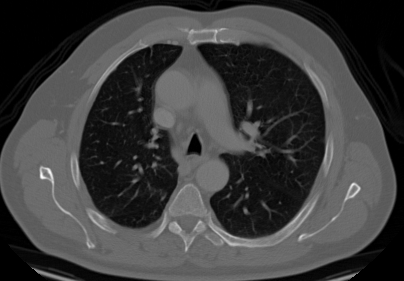

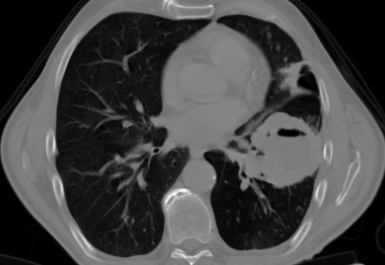

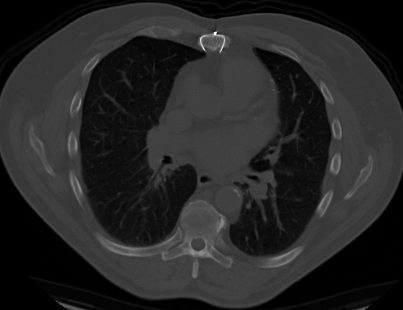

In [ ]:
# Walk through the directory '/content/Data/Train'
for root, dirs, files in os.walk('/content/Data/Train'):
    try:
        # Construct the full path to the first file in the current directory
        pth = f'{root}/{files[0]}'

        # Open the image using the PIL library
        im = Image.open(pth)

        # Display the image
        display(im)

    except Exception as e:
        # If an exception occurs (e.g., the directory is empty or an image cannot be opened), continue to the next iteration
        continue




In [ ]:
# Create an empty DataFrame with columns 'dir' and 'labels'
data_df = pd.DataFrame(columns=['dir', 'labels'])

# Create a list 'adeno' with file paths and labels for 'adenocarcinoma' class
adeno = [
    [f'/content/drive/MyDrive/Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/{x}', 'adenocacirnoma']
    for x in os.listdir('/content/drive/MyDrive/Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib')
]

# Create a list 'large' with file paths and labels for 'large' class
large = [
    [f'/content/drive/MyDrive/Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/{x}', 'large']
    for x in os.listdir('/content/drive/MyDrive/Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa')
]

# Create a list 'squam' with file paths and labels for 'squamous' class
squam = [
    [f'/content/drive/MyDrive/Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/{x}', 'squamous']
    for x in os.listdir('/content/drive/MyDrive/Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa')
]

# Create a list 'normal' with file paths and labels for 'normal' class
normal = [
    [f'/content/drive/MyDrive/Data/train/normal/ {x}', 'normal']
    for x in os.listdir('/content/drive/MyDrive/Data/train/normal')
]

# Concatenate the lists of file paths and labels into a NumPy array and assign it to the 'dir' and 'labels' columns of the DataFrame
data_df[['dir', 'labels']] = np.concatenate((adeno, large, squam, normal), axis=0)


In [ ]:
# Split the 'data_df' DataFrame into training and testing sets
# The 'stratify' parameter ensures that the class distribution is preserved in the split
train_df, test_df = train_test_split(data_df, train_size=.4, random_state=0, stratify=data_df['labels'])


In [ ]:
# ImageDataGenerator: This class from Keras provides real-time data augmentation during model training.

datagen = ImageDataGenerator(
    rescale=1/255,  # Rescale pixel values to the range [0, 1]. Common preprocessing step for neural networks.
    rotation_range=60,  # Randomly rotate images in the range [0, 60] degrees.
    shear_range=0.1,  # Apply shear transformation with a shear intensity of 0.1.
    zoom_range=0.1,  # Randomly zoom images by up to 10%.
    fill_mode='nearest',  # Strategy for filling in newly created pixels during transformations.
    horizontal_flip=True,  # Randomly flip images horizontally.
    vertical_flip=True,  # Randomly flip images vertically.
    validation_split=0.4  # Fraction of the dataset to reserve for validation. Images will be split based on this fraction.
)


In [ ]:
# Initialize an empty list to store class labels
kelas = []

# Iterate over the directories in '/content/drive/MyDrive/Data/test' in reverse order
# This assumes that the directories correspond to class labels
for x in reversed(os.listdir('/content/drive/MyDrive/Data/test')):
    # Append each class label to the 'kelas' list
    kelas.append(x)

# Print the list of class labels
print(kelas)


['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']


In [ ]:
# Create a training data generator using ImageDataGenerator
train_gen = datagen.flow_from_directory(
    '/content/drive/MyDrive/Data/train',  # Directory containing training images
    target_size=(200, 200),  # Resize images to 200px x 200px
    batch_size=16,  # Number of images per batch
    color_mode='grayscale',  # Use grayscale images
    classes=kelas,  # List of class names
    class_mode='categorical',  # Use categorical labels for classification
    seed=seed,  # Random seed for reproducibility
)

# Create a validation data generator using ImageDataGenerator
val_gen = datagen.flow_from_directory(
    '/content/drive/MyDrive/Data/valid',  # Directory containing validation images
    target_size=(200, 200),  # Resize images to 200px x 200px
    batch_size=16,  # Number of images per batch
    color_mode='grayscale',  # Use grayscale images
    classes=kelas,  # List of class names
    class_mode='categorical',  # Use categorical labels for classification
    shuffle=False,  # Do not shuffle the data (important for evaluation)
    seed=seed,  # Random seed for reproducibility
)


Found 148 images belonging to 4 classes.
Found 13 images belonging to 4 classes.


In [ ]:
# Define a Sequential model
model = keras.models.Sequential([
    # Convolutional layer with 64 filters, each of size (3, 3), ReLU activation, and input shape (200, 200, 1)
    keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(200, 200, 1)),

    # MaxPooling layer with pool size (2, 2)
    keras.layers.MaxPooling2D((2, 2)),

    # Convolutional layer with 128 filters, each of size (3, 3), and ReLU activation
    keras.layers.Conv2D(128, (3, 3), activation='relu'),

    # MaxPooling layer with pool size (2, 2)
    keras.layers.MaxPooling2D((2, 2)),

    # Convolutional layer with 256 filters, each of size (3, 3), and ReLU activation
    keras.layers.Conv2D(256, (3, 3), activation='relu'),

    # MaxPooling layer with pool size (2, 2)
    keras.layers.MaxPooling2D((2, 2)),

    # Convolutional layer with 512 filters, each of size (3, 3), and ReLU activation
    keras.layers.Conv2D(512, (3, 3), activation='relu'),

    # MaxPooling layer with pool size (2, 2)
    keras.layers.MaxPooling2D((2, 2)),

    # Convolutional layer with 512 filters, each of size (3, 3), and ReLU activation
    keras.layers.Conv2D(512, (3, 3), activation='relu'),

    # MaxPooling layer with pool size (2, 2)
    keras.layers.MaxPooling2D((2, 2)),

    # Convolutional layer with 1024 filters, each of size (3, 3), and ReLU activation
    keras.layers.Conv2D(1024, (3, 3), activation='relu'),

    # MaxPooling layer with pool size (2, 2)
    keras.layers.MaxPooling2D((2, 2)),

    # Flatten layer to convert the data to 1D
    keras.layers.Flatten(),

    # BatchNormalization layer for standard scaling
    keras.layers.BatchNormalization(),

    # Dense layer with 128 units and ReLU activation
    keras.layers.Dense(128, activation='relu'),

    # Dense layer with 128 units and ReLU activation
    keras.layers.Dense(128, activation='relu'),

    # BatchNormalization layer for standard scaling
    keras.layers.BatchNormalization(),

    # Output layer with 4 units (number of classes) and softmax activation for multi-class classification
    keras.layers.Dense(4, activation='softmax')
])

# Display the summary of the model architecture
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 99, 99, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 48, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 23, 23, 256)       0

In [ ]:
# Define a Sequential model
model = keras.models.Sequential([
    # Convolutional layer with 64 filters, each of size (3, 3), ReLU activation, and input shape (200, 200, 1)
    keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(200, 200, 1)),

    # MaxPooling layer with pool size (2, 2)
    keras.layers.MaxPooling2D((2, 2)),

    # Convolutional layer with 128 filters, each of size (3, 3), and ReLU activation
    keras.layers.Conv2D(128, (3, 3), activation='relu'),

    # MaxPooling layer with pool size (2, 2)
    keras.layers.MaxPooling2D((2, 2)),

    # Convolutional layer with 256 filters, each of size (3, 3), and ReLU activation
    keras.layers.Conv2D(256, (3, 3), activation='relu'),

    # MaxPooling layer with pool size (2, 2)
    keras.layers.MaxPooling2D((2, 2)),

    # Convolutional layer with 512 filters, each of size (3, 3), and ReLU activation
    keras.layers.Conv2D(512, (3, 3), activation='relu'),

    # MaxPooling layer with pool size (2, 2)
    keras.layers.MaxPooling2D((2, 2)),

    # Convolutional layer with 512 filters, each of size (3, 3), and ReLU activation
    keras.layers.Conv2D(512, (3, 3), activation='relu'),

    # MaxPooling layer with pool size (2, 2)
    keras.layers.MaxPooling2D((2, 2)),

    # Convolutional layer with 1024 filters, each of size (3, 3), and ReLU activation
    keras.layers.Conv2D(1024, (3, 3), activation='relu'),

    # MaxPooling layer with pool size (2, 2)
    keras.layers.MaxPooling2D((2, 2)),

    # Flatten layer to convert the data to 1D
    keras.layers.Flatten(),

    # BatchNormalization layer for standard scaling
    keras.layers.BatchNormalization(),

    # Dense layer with 128 units and ReLU activation
    keras.layers.Dense(128, activation='relu'),

    # Dense layer with 128 units and ReLU activation
    keras.layers.Dense(128, activation='relu'),

    # BatchNormalization layer for standard scaling
    keras.layers.BatchNormalization(),

    # Output layer with 4 units (number of classes) and softmax activation for multi-class classification
    keras.layers.Dense(4, activation='softmax')
])

# Display the summary of the model architecture
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 99, 99, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 48, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 23, 23, 256)       0

In [ ]:
# Define a Sequential model
model = keras.models.Sequential([
    # Convolutional layer with 64 filters, each of size (3, 3), ReLU activation, and input shape (200, 200, 1)
    keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(200, 200, 1)),

    # MaxPooling layer with pool size (2, 2)
    keras.layers.MaxPooling2D((2, 2)),

    # Convolutional layer with 128 filters, each of size (3, 3), and ReLU activation
    keras.layers.Conv2D(128, (3, 3), activation='relu'),

    # MaxPooling layer with pool size (2, 2)
    keras.layers.MaxPooling2D((2, 2)),

    # Convolutional layer with 256 filters, each of size (3, 3), and ReLU activation
    keras.layers.Conv2D(256, (3, 3), activation='relu'),

    # MaxPooling layer with pool size (2, 2)
    keras.layers.MaxPooling2D((2, 2)),

    # Convolutional layer with 512 filters, each of size (3, 3), and ReLU activation
    keras.layers.Conv2D(512, (3, 3), activation='relu'),

    # MaxPooling layer with pool size (2, 2)
    keras.layers.MaxPooling2D((2, 2)),

    # Convolutional layer with 512 filters, each of size (3, 3), and ReLU activation
    keras.layers.Conv2D(512, (3, 3), activation='relu'),

    # MaxPooling layer with pool size (2, 2)
    keras.layers.MaxPooling2D((2, 2)),

    # Convolutional layer with 1024 filters, each of size (3, 3), and ReLU activation
    keras.layers.Conv2D(1024, (3, 3), activation='relu'),

    # MaxPooling layer with pool size (2, 2)
    keras.layers.MaxPooling2D((2, 2)),

    # Flatten layer to convert the data to 1D
    keras.layers.Flatten(),

    # BatchNormalization layer for standard scaling
    keras.layers.BatchNormalization(),

    # Dense layer with 128 units and ReLU activation
    keras.layers.Dense(128, activation='relu'),

    # Dense layer with 128 units and ReLU activation
    keras.layers.Dense(128, activation='relu'),

    # BatchNormalization layer for standard scaling
    keras.layers.BatchNormalization(),

    # Output layer with 4 units (number of classes) and softmax activation for multi-class classification
    keras.layers.Dense(4, activation='softmax')
])

# Display the summary of the model architecture
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 99, 99, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 48, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 23, 23, 256)       0

In [ ]:
import tensorflow as tf

tf.keras.layers.Conv2D(
    filters=16,  # Number of filters in the convolution
    kernel_size=(3, 3),  # Size of the convolutional kernel
    activation='relu',  # Activation function, e.g., 'relu'
    input_shape=(64, 64, 3)  # Input shape of the data (height, width, channels)
)


In [ ]:
# Compile the model with specified optimizer, loss function, and evaluation metrics
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=1e-3, momentum=0.3, weight_decay=0.02),  # Stochastic Gradient Descent (SGD) optimizer with specified parameters
    loss=keras.losses.CategoricalCrossentropy(),  # Categorical Crossentropy loss for multi-class classification
    metrics=[
        keras.metrics.CategoricalAccuracy(name='accuracy'),  # Accuracy metric
        tfa.metrics.F1Score(4, average='macro'),  # F1 Score metric with macro averaging for multi-class classification
        keras.metrics.LogCoshError(name='logcosh'),  # Logarithm of the hyperbolic cosine of the prediction error
    ]
)


In [ ]:
# Define a list of callbacks to be applied during training
cb = [
    # EarlyStopping callback to stop training if the validation performance doesn't improve for 'patience' epochs
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),

    # ReduceLROnPlateau callback to reduce learning rate if the validation performance plateaus
    keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=3, min_lr=6e-6),

    # ModelCheckpoint callback to save the model with the best validation F1 Score
    keras.callbacks.ModelCheckpoint(
        'keras-rps.h5',
        monitor='val_f1_score',
        save_best_only=True,
        save_weights_only=False,
        mode='max'
    )
]

# Train the model using the training generator and validate on the validation generator
history = model.fit(
    train_gen,  # Training data generator
    epochs=50,  # Number of training epochs
    validation_data=val_gen,  # Validation data generator
    callbacks=cb,  # List of callbacks to be applied during training
    verbose=1  # Verbosity mode (0: silent, 1: progress bar, 2: one line per epoch)
)


Epoch 1/50
10/10 [==============================] - 93s 9s/step - loss: 1.6294 - accuracy: 0.2230 - f1_score: 0.0912 - logcosh: 0.0988 - val_loss: 1.3672 - val_accuracy: 1.0000 - val_f1_score: 0.2500 - val_logcosh: 0.0867 - lr: 0.0010
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 63s 6s/step - loss: 1.5246 - accuracy: 0.2703 - f1_score: 0.1064 - logcosh: 0.0940 - val_loss: 1.3174 - val_accuracy: 1.0000 - val_f1_score: 0.2500 - val_logcosh: 0.0839 - lr: 0.0010
Epoch 3/50
10/10 [==============================] - 63s 6s/step - loss: 1.4901 - accuracy: 0.2770 - f1_score: 0.1085 - logcosh: 0.0928 - val_loss: 1.2819 - val_accuracy: 1.0000 - val_f1_score: 0.2500 - val_logcosh: 0.0818 - lr: 0.0010
Epoch 4/50
10/10 [==============================] - 64s 6s/step - loss: 1.4533 - accuracy: 0.2703 - f1_score: 0.1064 - logcosh: 0.0922 - val_loss: 1.2538 - val_accuracy: 1.0000 - val_f1_score: 0.2500 - val_logcosh: 0.0801 - lr: 0.0010
Epoch 5/50
10/10 [==============================] - 63s 6s/step - loss: 1.4005 - accuracy: 0.3108 - f1_score: 0.1186 - logcosh: 0.0869 - val_loss: 1.2277 - val_accuracy: 1.0000 - val_f1_score: 0.2500 - val_logcosh: 0.0785 - lr: 0.0010
Epoch 6/50
10/10 [==============================] - 63s 6s/step - loss:

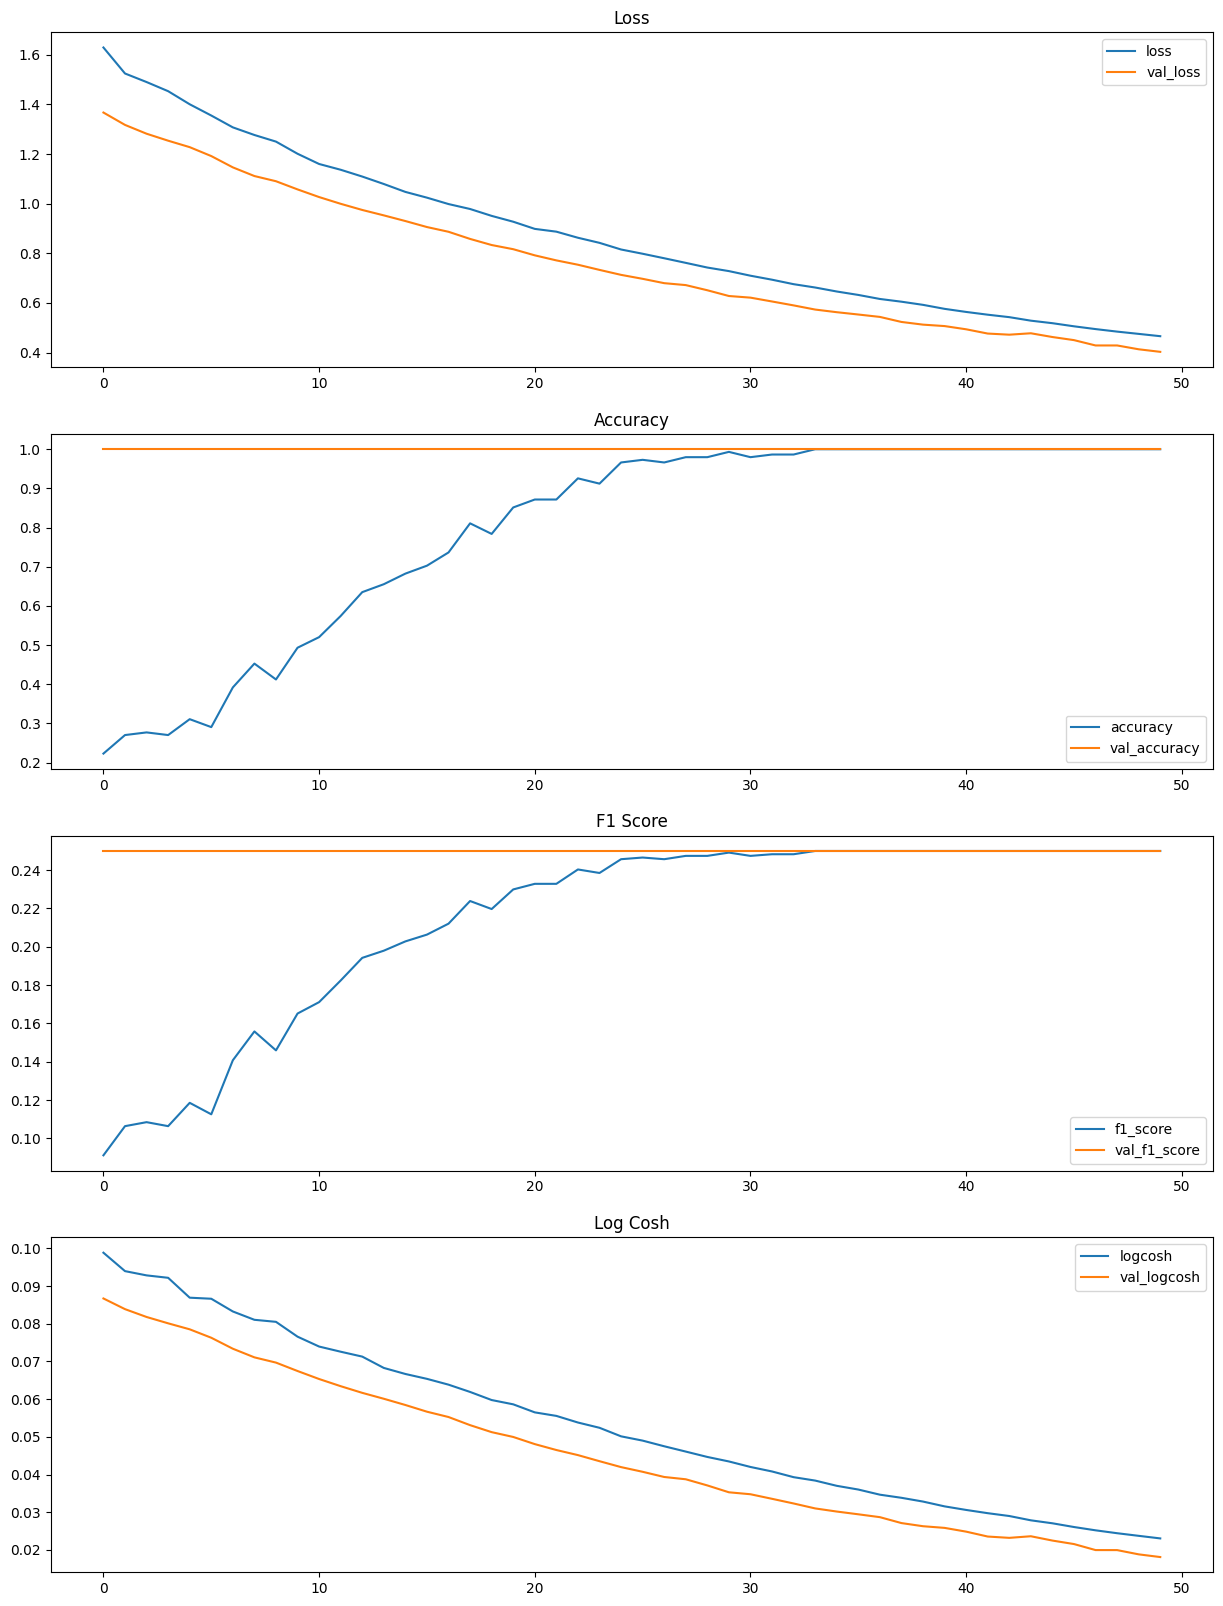

In [ ]:
# Create a DataFrame 'history_df' from the history object returned after training a neural network
history_df = pd.DataFrame(history.history)

# Create a subplot with 4 rows and 1 column of subplots, each with a specified size
f, axes = plt.subplots(4, 1, figsize=(15, 20))

# Flatten the array of subplots to a 1D array
axe = axes.ravel()

# Plot the training and validation loss on the first subplot
history_df[['loss', 'val_loss']].plot.line(ax=axe[0], title='Loss')

# Plot the training and validation accuracy on the second subplot
history_df[['accuracy', 'val_accuracy']].plot.line(ax=axe[1], title='Accuracy')

# Plot the training and validation F1 Score on the third subplot
history_df[['f1_score', 'val_f1_score']].plot.line(ax=axe[2], title='F1 Score')

# Plot the training and validation Log Cosh on the fourth subplot
history_df[['logcosh', 'val_logcosh']].plot.line(ax=axe[3], title='Log Cosh')

# Display the subplots
plt.show()


In [ ]:
# Evaluation results as needed
model.evaluate(val_gen)


1/1 [==============================] - 1s 1s/step - loss: 0.4103 - accuracy: 1.0000 - f1_score: 0.2500 - logcosh: 0.0186


[0.41030099987983704, 1.0, 0.25, 0.018626127392053604]

In [ ]:
# Save the entire model (architecture, optimizer, and learned weights) to a file
model.save('model-no-callback.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
kelas   #class labels

['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']

In [ ]:
# Predict the class probabilities for the validation data using the trained model
yhat = model.predict(val_gen)

# Convert the predicted probabilities to class labels using argmax
yhat = np.array([np.argmax(x) for x in yhat])

# Map numerical class labels to corresponding class names
yhat = np.array(['adenocarcinoma' if x == 0 else 'large cell' if x == 1 else 'normal' if x == 2 else 'squamous' for x in yhat])

# Print the predicted class labels
print(yhat)


1/1 [==============================] - 2s 2s/step
['normal' 'normal' 'normal' 'normal' 'normal' 'normal' 'normal' 'normal'
 'normal' 'normal' 'normal' 'normal' 'normal']


In [ ]:
len(yhat)

13